In [174]:
import pandas as pd 
import numpy as np 
from os import listdir
pd.set_option('display.max_columns', None)
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier 
from sklearn.ensemble import BaggingClassifier
from sklearn.mixture import BayesianGaussianMixture
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import ComplementNB
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import ExtraTreesClassifier 
from sklearn.mixture import GaussianMixture 
from sklearn.naive_bayes import GaussianNB
from sklearn.gaussian_process import GaussianProcessClassifier 
from sklearn.ensemble import GradientBoostingClassifier 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.semi_supervised import LabelPropagation
from sklearn.semi_supervised import LabelSpreading
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV 
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import NuSVC
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier 
from sklearn.svm import SVC 
from sklearn.model_selection import cross_val_score 
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score 
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid 
from sklearn.metrics import classification_report 
from sklearn import preprocessing 
import category_encoders as ce 
from sklearn.externals import joblib 
from os import path 
from dill.source import getname 
import matplotlib.pyplot as plt 

## Reading in Data:

### Bills: Bill metadata and computed subject areas
### Bill ideologies: Bill ideology scores computed from subject-specific scores of cosponsors
### Member ideologies: Subject-specific ideology scores for all legislators as computed from their vote records in each subject 
### Legislators: Legislator records including bioguide ids to identify unique legislator records 

In [28]:
bills = pd.read_csv('data_store/dataframes/full_congress_level_df8.csv')
bill_ides = pd.read_csv('data_store/ides_by_bill/ide_distance_df.csv') 
member_ides = pd.read_csv('all_member_ideologies.csv') 
member_id_list = list(member_ides['bioguide_id'].unique())
member_models = listdir('member_models/') 
legislators = pd.read_csv('all_legislators.csv')  

/home/william/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (2,3,4,7,8,9,12,16,17,18,20,21,24,25,26,29,37,38,39,42,45,46,47,50,53,54,55,58,61,62,63,66,69,70,71,74,77,78,79,82,85,86,87,90,93,94,95,98,101,102,103,106,109,110,111,114,115,116,117,144,145,146,150,151,152,154,155,158,159,160,163,166,167,168,170,171,174,175,176,178,179,182,183,184,187,194,195,196,200,201,202,206,208,211,212,213,215,216,221,222,223,226,229,230,231,234) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Function to compile a dictionary including legislator identification features and the best scoring model for that legislator 

In [141]:
def names_and_ids(id_list, legislator_df, model_list):
    full_names = []
    member_ids = []
    top_models = []
    for member_id in member_id_list:
        substring = member_id + '_model_v'
        matches = list(filter(lambda x: substring in x, model_list))
        best_version = len(matches)
        if best_version > 0: 
            member_ids.append(member_id)
            member_df = legislator_df[legislator_df[
                'bioguide_id'] == member_id].reset_index(drop=True)
            if pd.isna(member_df['suffix'][0]) == True:
                full_name = member_df['first_name'].item() + ' ' + member_df[
                    'last_name'].item()
                full_names.append(full_name)
            else:
                full_name = member_df['first_name'].item() + ' ' + member_df[
                    'last_name'].item() + ' ' + member_df['suffix'].item()
                full_names.append(full_name)
        
            top_model = substring + str(best_version) + '.pkl'
            top_models.append(top_model)
        else:
            pass 
    model_records_dict = {'id': member_ids, 'name': full_names,
                          'best-scoring model file': top_models}
    return model_records_dict  

### Function to build the member-specific dataframes upon which their vote prediction models are applied 

In [106]:
def vote_df_builder(bioguide_id, bill_df, bill_ides_df):
    member_df = pd.read_csv('data_store/member_ideology/' +str(
        bioguide_id) +'_ideology_df.csv')
    member_df['congress'] = member_df['congress'].astype(int)
    congress_numbers = member_df['congress'].unique()
    vote_dfs = []
    for congress_number in congress_numbers:
        sub_df = pd.read_csv('data_store/votes/congress_'+str(
            congress_number)+ '_member_votes.csv')
        vote_dfs.append(sub_df)
    vote_df = pd.concat(vote_dfs)
    vote_df = vote_df[vote_df['bioguide_id'] == bioguide_id].reset_index(drop=True)
    results_list = []
    for string in vote_df['bill_id']:
        if 'E' in string:
            results_list.append(1)
        elif 'P' in string:
            results_list.append(1)
        elif 'J' in string:
            results_list.append(1)
        else:
            results_list.append(0) 
    vote_df['check_col'] = results_list
    vote_df = vote_df[vote_df['check_col'] == 0]
    vote_df = vote_df.drop('check_col', axis=1)
    vote_df = vote_df.reset_index(drop=True)
    vote_df = vote_df[['vote_id', 'vote']] 
    merged0 = pd.merge(member_df, vote_df, on='vote_id', how='left')
    bill_df = bill_df[['bill_id', 'major_label 1', 'major_label 2', 'major_label 3']]
    merged = pd.merge(merged0, bill_df, on='bill_id', how='left')
    bill_ids = []
    vote_ids = []
    member_label_1_scores = []
    member_label_2_scores = []
    member_label_3_scores = []
    merged['major_label 1'] = merged['major_label 1'].astype(int)
    merged['major_label 2'] = merged['major_label 2'].astype(int)
    merged['major_label 3'] = merged['major_label 3'].astype(int)
    merged.dropna(axis=0, inplace=True)
    merged.reset_index(drop=True, inplace=True)
    for row in range(len(merged)):
        label_1 = 'topic_' + str(merged['major_label 1'][row].item()) 
        label_2 = 'topic_' + str(merged['major_label 2'][row].item())
        label_3 = 'topic_' + str(merged['major_label 3'][row].item())
        vote_ids.append(merged['vote_id'][row])
        bill_ids.append(merged['bill_id'][row])
        member_label_1_scores.append(merged[label_1][row])
        member_label_2_scores.append(merged[label_2][row])
        member_label_3_scores.append(merged[label_3][row]) 
    output_dict = {'vote_id': vote_ids, 'bill_id': bill_ids,
                   'member label 1 score': member_label_1_scores,
                   'member label 2 score': member_label_2_scores,
                   'member label 3 score': member_label_3_scores}
    label_df = pd.DataFrame(output_dict)
    output_df0 = pd.merge(merged, label_df, on=['vote_id', 'bill_id'], how='left')
    pre_merge_bill_ides = bill_ides_df.drop('congress', axis=1) 
    output_df = pd.merge(output_df0, pre_merge_bill_ides, on='bill_id', how='left')
    x1 = 'bill avg_label_1 ideology'
    y1 = 'bill avg_label_2 ideology'
    z1 = 'bill avg_label_3 ideology'
    x2 = 'member label 1 score' 
    y2 = 'member label 2 score'
    z2 = 'member label 3 score'
    drop_cols = ['thomas_id', 'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5',
                'topic_6', 'topic_7', 'topic_8', 'topic_9', 'topic_10', 'topic_12',
                'topic_13', 'topic_14', 'topic_15', 'topic_16', 'topic_17', 'topic_18',
                'topic_19', 'topic_20', 'topic_21', 'topic_99', 'member label 1 score',
                'member label 2 score', 'member label 3 score', 'bill avg_label_1 ideology',
                'bill avg_label_2 ideology', 'bill avg_label_3 ideology']
    output_df['ideological distance'] = np.sqrt((output_df[x1]-output_df[x2])**2 +(
    output_df[y1]-output_df[y2])**2 + (output_df[z1]-output_df[z2])**2)
    output_df = output_df.drop(drop_cols, axis=1)
    output_df.dropna(axis=0, inplace=True)
    output_df['major_label 1'] = output_df['major_label 1'].astype(str)
    output_df['major_label 2'] = output_df['major_label 2'].astype(str)
    output_df['major_label 3'] = output_df['major_label 3'].astype(str)
    return output_df 

In [105]:
def onehot_encoder(df):
    y = df['vote']
    X = df.drop('vote', axis=1) 
    ohe = ce.OneHotEncoder(handle_unknown='ignore', use_cat_names=True)
    df_ohe = ohe.fit_transform(X)
    df_ohe['vote'] = y 
    return df_ohe  

### Function to refit each legislator's best-scoring model to the entire dataset and then report accuracy achieved on the test set 

In [116]:
def model_score(df, y_col, model_file):
    n_samples = len(df)
    X = df.drop(y_col, axis=1)
    y = df[y_col]
    model_path = 'member_models/' + model_file
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42)
    algo = joblib.load(model_path)
    model_name = type(algo).__name__ 
    algo.fit(X, y)
    score = algo.score(X_test, y_test)
    score = str(round(score, 2)) +'%'
    output_dict = {'score': score, 'model_name': model_name}
    return output_dict 

In [139]:
def compile_results(records_dict):
    bioguide_ids = []
    member_names = []
    scores = []
    model_names = []
    model_files = []
    
    for member in range(len(records_dict['id'])):
        member_id = records_dict['id'][member]
        member_name = records_dict['name'][member]
        model_file = records_dict['best-scoring model file'][member] 
        member_votes = vote_df_builder(member_id, bills, bill_ides)
        member_votes = member_votes.drop(['bill_id', 'vote_id', 'bioguide_id',
                                          'party'], axis=1)
        member_votes = onehot_encoder(member_votes)
        member_votes = member_votes[member_votes['vote'] != 0].reset_index(drop=True)
        results = model_score(member_votes, 'vote', model_file)
        bioguide_ids.append(member_id)
        member_names.append(member_name)
        scores.append(results['score'])
        model_names.append(results['model_name'])
        model_files.append(model_file)

    output_dict = {'bioguide_id': bioguide_ids, 'legislator_name': member_names,
                   'accuracy': scores, 'model_name': model_names, 'model_file': model_files}
    output_df = pd.DataFrame(output_dict)
    output_df.to_csv('member_model_results.csv', index=False) 
    return output_df 

In [142]:
model_records = names_and_ids(member_id_list, legislators, member_models) 

In [1]:
full_results = compile_results(model_records) 

In [151]:
full_results['accuracy_float'] = full_results['accuracy'].str.replace('%','')

In [173]:
full_results

,bioguide_id,legislator_name,accuracy,model_name,model_file,accuracy_float
0,A000216,Leslie Arends,0.98%,GradientBoostingClassifier,A000216_model_v2.pkl,0.98
1,A000222,Thomas Ashley,0.82%,GradientBoostingClassifier,A000222_model_v2.pkl,0.82
2,B000178,William Barrett,0.84%,XGBClassifier,B000178_model_v1.pkl,0.84
3,B000371,Charles Bennett,0.99%,RandomForestClassifier,B000371_model_v3.pkl,0.99
4,B000550,John Blatnik,0.84%,AdaBoostClassifier,B000550_model_v1.pkl,0.84
5,B000600,Edward Boland,0.81%,XGBClassifier,B000600_model_v1.pkl,0.81
6,B000605,Richard Bolling,0.87%,XGBClassifier,B000605_model_v1.pkl,0.87
7,B000736,John Brademas,0.89%,GradientBoostingClassifier,B000736_model_v2.pkl,0.89
8,B000778,William Bray,0.85%,XGBClassifier,B000778_model_v1.pkl,0.85
9,B000880,Jack Brooks,0.78%,XGBClassifier,B000880_model_v1.pkl,0.78


In [155]:
full_results['accuracy_float'] = full_results['accuracy_float'].astype('float')

In [159]:
full_results['accuracy_float'].describe()

count    1602.000000
mean        0.864507
std         0.076778
min         0.600000
25%         0.810000
50%         0.860000
75%         0.900000
max         1.000000
Name: accuracy_float, dtype: float64

In [161]:
full_results['model_name'].value_counts() 

GradientBoostingClassifier    517
XGBClassifier                 458
AdaBoostClassifier            200
RandomForestClassifier        120
ExtraTreesClassifier           81
LogisticRegression             72
BernoulliNB                    64
LogisticRegressionCV           50
BaggingClassifier              40
Name: model_name, dtype: int64

In [171]:
full_results['accuracy_float'].min()

0.6

In [175]:
full_results['accuracy'] = full_results['accuracy_float']

(array([  1.,   5.,  16.,  79., 182., 312., 353., 299., 101., 254.]),
 array([0.6 , 0.64, 0.68, 0.72, 0.76, 0.8 , 0.84, 0.88, 0.92, 0.96, 1.  ]),
 <a list of 10 Patch objects>)

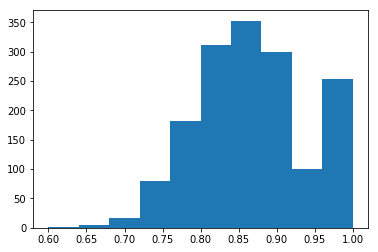

In [176]:
plt.hist(full_results['accuracy'])

In [ ]:
full_results.to_csv('model_results.csv', index=False)